# Fruits Dataset

## _Extract Data_

In [2]:
import os
import numpy as np
import glob
import cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
'''
tr_pin = glob.glob('fruits/Training/Pineapple/*.jpg')
tr_limes = glob.glob('fruits/Training/Limes/*.jpg')
tr_ban = glob.glob('fruits/Training/Banana/*.jpg')

train_pin = []
for img in tr_pin:
    img = cv2.imread(img)
    img = np.reshape(img,(100*100,3))
    train_pin.append(img)
train_pin = np.asarray(train_pin)
print("train_pin shape: ",train_pin.shape)
    
train_limes = []
for img in tr_limes:
    img = cv2.imread(img)
    img = np.reshape(img,(100*100,3))
    train_limes.append(img)
train_limes = np.asarray(train_limes)
print("train_limes shape: ",train_limes.shape)

train_ban = []
for img in tr_ban:
    img = cv2.imread(img)
    img = np.reshape(img,(100*100,3))
    train_ban.append(img)
train_ban = np.asarray(train_ban)
print("train_ban shape: ",train_ban.shape)
'''

'\ntr_pin = glob.glob(\'fruits/Training/Pineapple/*.jpg\')\ntr_limes = glob.glob(\'fruits/Training/Limes/*.jpg\')\ntr_ban = glob.glob(\'fruits/Training/Banana/*.jpg\')\n\ntrain_pin = []\nfor img in tr_pin:\n    img = cv2.imread(img)\n    img = np.reshape(img,(100*100,3))\n    train_pin.append(img)\ntrain_pin = np.asarray(train_pin)\nprint("train_pin shape: ",train_pin.shape)\n    \ntrain_limes = []\nfor img in tr_limes:\n    img = cv2.imread(img)\n    img = np.reshape(img,(100*100,3))\n    train_limes.append(img)\ntrain_limes = np.asarray(train_limes)\nprint("train_limes shape: ",train_limes.shape)\n\ntrain_ban = []\nfor img in tr_ban:\n    img = cv2.imread(img)\n    img = np.reshape(img,(100*100,3))\n    train_ban.append(img)\ntrain_ban = np.asarray(train_ban)\nprint("train_ban shape: ",train_ban.shape)\n'

In [3]:
fruits = []
labels = [] 
fruits_f = []
for fruit_dir in glob.glob("fruits/Training/*"):
    fruit_dir = fruit_dir.replace('\\', '/')
    fruit_label = fruit_dir.split("/")[-1]
    for img in glob.glob(os.path.join(fruit_dir, "*.jpg")):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        
        img = cv2.resize(img, (45, 45))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        imgf = np.reshape(img,(45*45,3))
        fruits.append(img)
        fruits_f.append(imgf)
        labels.append(fruit_label)
fruits = np.array(fruits)
labels = np.array(labels)
fruits_f = np.array(fruits_f)
print(fruits.shape,labels.shape)
print(labels)

(1470, 45, 45, 3) (1470,)
['Banana' 'Banana' 'Banana' ... 'Pineapple' 'Pineapple' 'Pineapple']


In [4]:
id_to_labels = {i:v for i,v in enumerate(np.unique(labels))}
print(id_to_labels)
label_to_ids = {v:i for i,v in id_to_labels.items()}
label_ids = np.array([label_to_ids[x] for x in labels])
label_names = [v for i,v in id_to_labels.items()]
print(label_ids)

{0: 'Banana', 1: 'Limes', 2: 'Pineapple'}
[0 0 0 ... 2 2 2]


In [5]:
import numpy.linalg as la
images = np.array([i.flatten() for i in fruits])
print(images.shape)
m = np.mean(images)
im_bar = images - m

(1470, 6075)


Text(0,0.5,'Y (log scale)')

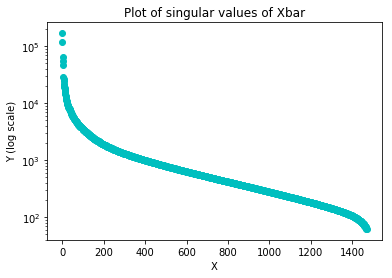

In [6]:
im_bar = im_bar.transpose()
%matplotlib inline
import matplotlib.pyplot as plt
U,s,VT = la.svd(im_bar)
fig = plt.figure()
x = np.arange(s.shape[0])
y = s
ax = fig.add_subplot(111)
plt.yscale('log')
ax.scatter(x, y, c='c', marker='o')
ax.set_title("Plot of singular values of Xbar")
ax.set_xlabel('X')
ax.set_ylabel('Y (log scale)')

In [7]:
#im_bar = im_bar.transpose()
#finding smallest k to encompass 90% of data
s_sum = 0
fnorm = la.norm(im_bar)**2

k = 0
for i in range(s.shape[0]):
    s_sum = s_sum + s[i]**2
    t = s_sum/fnorm
    if(t >= 0.964):
        k = i
        break
#top k principal components of Xbar

print("k is: ",k)

k is:  51


(51, 1470)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(6075, 1470)


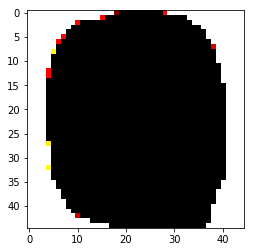

In [8]:
Uk = U[:,0:k]
features = Uk.transpose()@im_bar
print(features.shape)
recon = Uk@Uk.transpose()@im_bar
print(recon.shape)
r = np.random.randint(0,im_bar.shape[1])
img = np.reshape(recon[:,r],(45,45,3))
plt.imshow(img)

### Sklearn PCA

In [9]:
scaler = StandardScaler()
images_scaled = scaler.fit_transform([i.flatten() for i in fruits])
print(images_scaled.shape)
pca = PCA(n_components=50)
pca_result = pca.fit_transform(images_scaled)

(1470, 6075)


In [10]:
print(pca_result.shape)

(1470, 50)


(1470, 2)


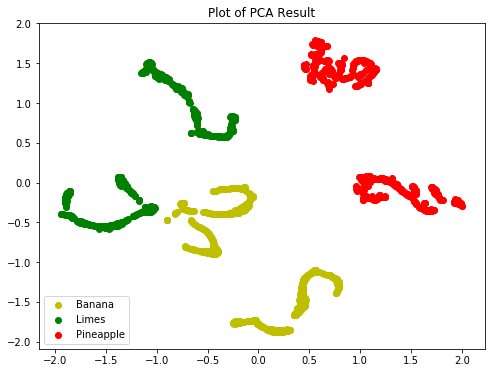

In [11]:
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
print(tsne_result_scaled.shape)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111)

for i in range(tsne_result_scaled.shape[0]):
    if (label_ids[i]==0):
        zerop = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='y', marker='o')
    if (label_ids[i]==1):
        onep = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='g', marker='o')
    if (label_ids[i]==2):
        twop = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='r', marker='o')
ax.set_title("Plot of PCA Result")
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend([zerop,onep,twop], ["Banana","Limes","Pineapple"],loc=3)
plt.show()

## Split into Training and Test Data

In [36]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, label_ids, test_size=0.25, random_state=42)

#### Train Model

In [37]:
svm_clf = svm.SVC()
svm_clf = svm_clf.fit(X_train, y_train) 

In [38]:
test_predictions = svm_clf.predict(X_test)

In [39]:
precision = accuracy_score(test_predictions, y_test) * 100
print("Training Accuracy with SVM: {0:.6f}".format(precision))

Training Accuracy with SVM: 94.293478


In [40]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(test_predictions, y_test,target_names=label_names))
print(confusion_matrix(test_predictions, y_test, labels=range(3)))

             precision    recall  f1-score   support

     Banana       0.83      1.00      0.91       103
      Limes       1.00      1.00      1.00       117
  Pineapple       1.00      0.86      0.92       148

avg / total       0.95      0.94      0.94       368

[[103   0   0]
 [  0 117   0]
 [ 21   0 127]]


### Test SVM Model on Validation Data

In [41]:
val_fruits = []
val_labels = [] 
val_fruits_f = []
for fruit_dir in glob.glob("fruits/Test/*"):
    fruit_dir = fruit_dir.replace('\\', '/')
    fruit_label = fruit_dir.split("/")[-1]
    for img in glob.glob(os.path.join(fruit_dir, "*.jpg")):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        
        img = cv2.resize(img, (45, 45))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        imgf = np.reshape(img,(45*45,3))
        val_fruits.append(img)
        val_fruits_f.append(imgf)
        val_labels.append(fruit_label)
val_fruits = np.array(val_fruits)
val_labels = np.array(val_labels)
val_fruits_f = np.array(val_fruits_f)
print(val_fruits.shape,val_labels.shape)

(498, 45, 45, 3) (498,)


In [42]:
val_label_ids = np.array([label_to_ids[i] for i in val_labels])
val_images_scaled = scaler.transform([i.flatten() for i in val_fruits])
val_pca_res = pca.transform(val_images_scaled)
print(val_pca_res.shape)

(498, 50)


(498, 2)


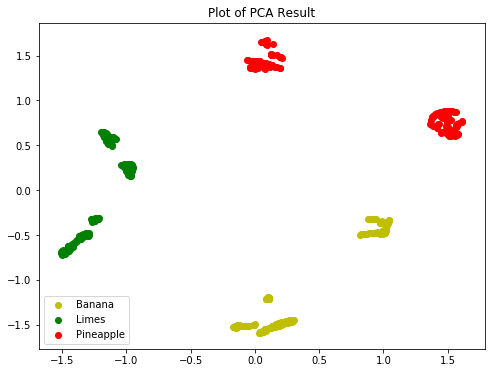

In [43]:
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(val_pca_res)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
print(tsne_result_scaled.shape)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111)

for i in range(tsne_result_scaled.shape[0]):
    if (val_label_ids[i]==0):
        zerop = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='y', marker='o')
    if (val_label_ids[i]==1):
        onep = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='g', marker='o')
    if (val_label_ids[i]==2):
        twop = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='r', marker='o')
ax.set_title("Plot of PCA Result")
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend([zerop,onep,twop], ["Banana","Limes","Pineapple"],loc=3)
plt.show()

In [44]:
test_predictions = svm_clf.predict(val_pca_res)

In [45]:
precision = accuracy_score(test_predictions, val_label_ids) * 100
print("Validation Accuracy with SVM: {0:.6f}".format(precision))

Validation Accuracy with SVM: 64.056225


# Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

## Binary Logistic Regression

In [123]:
import itertools
B= '\033[1m'
E= '\033[0m'

## Define function to plot matrix based on:
## [[True Non, False Fraud],[False Non, True Fraud]]

def plot_confusion_matrix(cm, title = 'Confusion Matrix'):
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuBuGn)
    plt.title(title)
    tick_marks = np.arange(len([0,1]))
    plt.xticks(tick_marks, ["Banana {0}","Lime {1}"], rotation=0)
    plt.yticks(tick_marks, ["Banana {0}","Lime {1}"])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.colorbar()
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.show()
    print(B+"Matrix Recall: "+E+ str(cm[1,1]/(cm[1,0] + cm[1,1])*100) +" %")
    print(B+"Matrix Precision: "+E+ str(cm[1,1]/(cm[1,1] + cm[0,1])*100) +" %")
    
def plot_confusion_matrix2(cm, title = 'Confusion Matrix'):
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuBuGn)
    plt.title(title)
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, ["Banana {0}","Lime {1}", "Pineapple {2}"], rotation=0)
    plt.yticks(tick_marks, ["Banana {0}","Lime {1}", "Pineapple {2}"])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.colorbar()
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.show()
    print(B+"Matrix Recall: "+E+ str(cm[1,1]/(cm[1,0] + cm[1,1])*100) +" %")
    print(B+"Matrix Precision: "+E+ str(cm[1,1]/(cm[1,1] + cm[0,1])*100) +" %")

Accuracy with LogisticRegressionCV: 100.000000


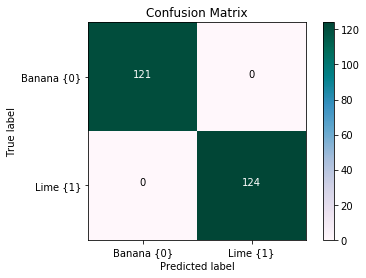

Matrix Recall: 100.0 %
Matrix Precision: 100.0 %


In [124]:
two_classes = []
two_classes_id = []
for i in range(0, label_ids.shape[0]):
    if(label_ids[i]!=2):
        two_classes.append(pca_result[i,:])
        two_classes_id.append(label_ids[i])
two_classes_id = np.array(two_classes_id)
two_classes = np.array(two_classes)

X_train, X_test, y_train, y_test = train_test_split(two_classes, two_classes_id, test_size=0.25, random_state=42)
clf = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)
predictions = clf.predict(X_test)

precision = accuracy_score(predictions, y_test) * 100
print("Accuracy with LogisticRegressionCV: {0:.6f}".format(precision))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix)

## Multi-class Logisitic Regression

Accuracy with LogisticRegressionCV: 100.000000


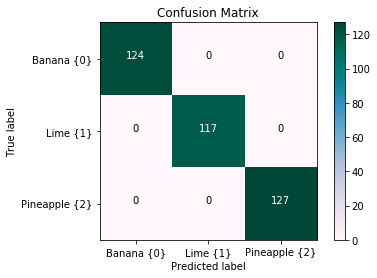

Matrix Recall: 100.0 %
Matrix Precision: 100.0 %


In [125]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, label_ids, test_size=0.25, random_state=42)
clf = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial').fit(X_train, y_train)
predictions = clf.predict(X_test)

precision = accuracy_score(predictions, y_test) * 100
print("Accuracy with LogisticRegressionCV: {0:.6f}".format(precision))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix2(cnf_matrix)

 # Classification Trees - Random Forests

Accuracy with RandomForest: 100.000000


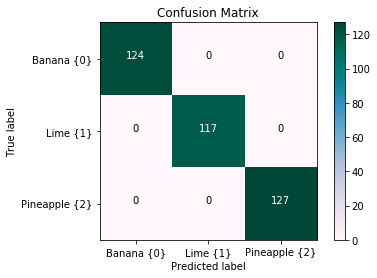

Matrix Recall: 100.0 %
Matrix Precision: 100.0 %


In [126]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10)
forest = forest.fit(X_train, y_train)
test_predictions = forest.predict(X_test)
precision = accuracy_score(test_predictions, y_test) * 100
print("Accuracy with RandomForest: {0:.6f}".format(precision))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix2(cnf_matrix)

Validation Accuracy with Random Forest: 100.000000


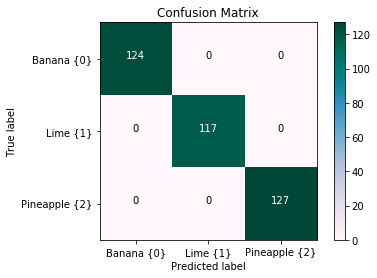

Matrix Recall: 100.0 %
Matrix Precision: 100.0 %


In [127]:
test_predictions = forest.predict(val_pca_res)
precision = accuracy_score(test_predictions, val_label_ids) * 100
print("Validation Accuracy with Random Forest: {0:.6f}".format(precision))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix2(cnf_matrix)